# Profiling User with LDA

We have to predict whether a user is going to cancel subscribtion from a news portal (downstream task). So, we have to profile a user from texts of articles he has read. And, there are 2 tasks to solve: 1 - creation of an article's vector, 2 - creation of user's vector.

### Libraries to install

In [1]:
# !pip install gensim
# !pip install razdel
# !pip install pymorphy2
# !pip install nltk

In [2]:
import pandas as pd
import numpy as np

import re
import nltk  # required to download stopwords - nltk.download('stopwords')
import pymorphy2  # required for normalization of words

from nltk.corpus import stopwords  # required to upload stopwords
from gensim.corpora.dictionary import Dictionary  # required to create dictionary
from razdel import tokenize  # required to tokenize a text - transform them into a list of words
# from nltk.tokenize import word_tokenize  # for English???

# https://www.nltk.org
# https://github.com/natasha/razdel

### uploading dataframe of articles

In [3]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


### uploading dataframe of users

In [4]:
users = pd.read_csv("users_articles.csv")
print(users.shape)
users.head(3)

(8000, 2)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


## PART 1 - Vectors of Articles

### downloading stopwords

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fross\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stopword_ru = stopwords.words('russian')
print(stopword_ru[:10])
print(len(stopword_ru))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']
151


### adding additional stopwards from file

In [7]:
with open('stopwords_additional_russian.txt', encoding="utf8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
print(stopword_ru[-10:])
len(stopword_ru)

['сообщает_риа_"новости"', 'передает_риа_"новости"', 'понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье', 'сообщил_журналист']


415

so, our dictionary of stopwords now has 415 words

### function to clean a text from special symbols

In [8]:
def clean_text(text):
    '''
    очистка текста
    на выходе очищеный текст
    '''
    
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

### demostration of how 'clean_text' works

In [9]:
clean_text('\n-I like 44 *pineapples!-')

<ipython-input-8-ab1f9a20047e>:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


'i like  pineapples'

### function to transform a text into tokenized list of words in their normal form

In [10]:
cache = {}
morph = pymorphy2.MorphAnalyzer()
def lemmatization(text):
    '''
    the function is required to transform a text/article into a list of words in their normal form
        [0] changing of type to `str` if not `str`
        [1] tokenization with razdel
        [2] checking whether a word starts with '-'
        [3] checking whether there is more than one symbol in a word
        [4] checking whether a word is in cashe
        [5] lemmatization of word - bringing it into its normal form
        [6] throwing out stopwords from final list of words
    '''
    
    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

an alternative to lemmatization is stemming which just shortens a word to its core/root

#### demonstration of how 'tokenize' (razdel.tokenize) works

In [11]:
[_ for _ in tokenize('Мама мыла раму')]

[Substring(0, 4, 'Мама'), Substring(5, 9, 'мыла'), Substring(10, 14, 'раму')]

In [12]:
[_ for _ in tokenize('Мама мыла раму')][1].text

'мыла'

#### demonstration of how 'morph' (pymorphy2.MorphAnalyzer()) works

In [13]:
pymorphy2.MorphAnalyzer().parse('нарушили')[0].normal_form

'нарушить'

#### demonstration of how 'lemmatization' works

In [14]:
lemmatization('Мама мыла раму')

['мама', 'мыло', 'рама']

### let's start 'clean_text', it is going to take some time...

In [15]:
print(news['title'][88])  # before

Футбольный клуб «Анжи» объявил об усилении тренерского штаба команды, об этом сообщаетnофициальный сайтnмахачкалинцев.nПомогать главному тренеру, Гусу Хиддинку, в тренировочном процессе призваны бывший сотрудник «Манчестер Юнайтед» Рене Меленстен (бывший помощник Алекса Фергюсона) и Хасанби Биджиев.nОба тренера имеют тренерскую категорию PRO. При этом Биджиев продолжит исполнение функций спортивного директора нашего клуба.nВ свою очередь медицинское подразделение штаба пополнят такие специалисты как массажист-терапевт Денни Флиттер (Великобритания, «Арсенал» Лондон), физиотерапевт Доминик Роган (Великобритания, «Эвертон»), тренер по физической подготовке Эдуардо Парра Гарсия (Испания, «Интер» Милан, «Ливерпуль»), специалист по спортивной науке Уорд Дирикс (Бельгия, «Гент»), массажист-терапевт Уильям Стори (Великобритания, «Вест Хэм») и тренер по физподготовке Брэм Суиннинен (Бельгия, БК «Химки»).


In [16]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 25.6 s


In [17]:
print(news['title'][88])  # after

футбольный клуб анжи объявил об усилении тренерского штаба команды об этом сообщаетnофициальный сайтnмахачкалинцевnпомогать главному тренеру гусу хиддинку в тренировочном процессе призваны бывший сотрудник манчестер юнайтед рене меленстен бывший помощник алекса фергюсона и хасанби биджиевnоба тренера имеют тренерскую категорию pro при этом биджиев продолжит исполнение функций спортивного директора нашего клубаnв свою очередь медицинское подразделение штаба пополнят такие специалисты как массажисттерапевт денни флиттер великобритания арсенал лондон физиотерапевт доминик роган великобритания эвертон тренер по физической подготовке эдуардо парра гарсия испания интер милан ливерпуль специалист по спортивной науке уорд дирикс бельгия гент массажисттерапевт уильям стори великобритания вест хэм и тренер по физподготовке брэм суиннинен бельгия бк химки


### let's start 'lemmatization', it is going to take long time...

In [18]:
print(news['title'][88])  # before

футбольный клуб анжи объявил об усилении тренерского штаба команды об этом сообщаетnофициальный сайтnмахачкалинцевnпомогать главному тренеру гусу хиддинку в тренировочном процессе призваны бывший сотрудник манчестер юнайтед рене меленстен бывший помощник алекса фергюсона и хасанби биджиевnоба тренера имеют тренерскую категорию pro при этом биджиев продолжит исполнение функций спортивного директора нашего клубаnв свою очередь медицинское подразделение штаба пополнят такие специалисты как массажисттерапевт денни флиттер великобритания арсенал лондон физиотерапевт доминик роган великобритания эвертон тренер по физической подготовке эдуардо парра гарсия испания интер милан ливерпуль специалист по спортивной науке уорд дирикс бельгия гент массажисттерапевт уильям стори великобритания вест хэм и тренер по физподготовке брэм суиннинен бельгия бк химки


In [19]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 42s


In [20]:
print(news['title'][88])  # after

['футбольный', 'клуб', 'анжи', 'объявить', 'усиление', 'тренерский', 'штаб', 'команда', 'официальный', 'сайт', 'махачкалинец', 'помогать', 'главный', 'тренер', 'гуса', 'хиддинк', 'тренировочный', 'процесс', 'призвать', 'бывший', 'сотрудник', 'манчестер', 'юнайтед', 'рен', 'меленстен', 'бывший', 'помощник', 'алекс', 'фергюсон', 'хасанби', 'биджиев', 'оба', 'тренер', 'иметь', 'тренерский', 'категория', 'pro', 'биджиев', 'продолжить', 'исполнение', 'функция', 'спортивный', 'директор', 'клуб', 'очередь', 'медицинский', 'подразделение', 'штаб', 'пополнить', 'специалист', 'массажисттерапевт', 'денни', 'флиттереть', 'великобритания', 'арсенал', 'лондон', 'физиотерапевт', 'доминик', 'рогать', 'великобритания', 'эвертон', 'тренер', 'физический', 'подготовка', 'эдуардо', 'парра', 'гарсия', 'испания', 'интер', 'милан', 'ливерпуль', 'специалист', 'спортивный', 'наука', 'уорд', 'дирикс', 'бельгия', 'гент', 'массажисттерапевт', 'уильям', 'стори', 'великобритания', 'вест', 'хэм', 'тренер', 'физподгот

### let's create corpus - a list of 'bag of words' sparse matrixes, each of which corresponds to a news

In [21]:
# creation of list of texts (texts are lists of cleanded and lemmatized words)
texts = [t for t in news['title'].values]

# creation of a corpus from a list of texts
common_dictionary = Dictionary(texts)  # creation of 'common_dictionary' - the list of all words in all documents;
                                       # words are normalized and stopwords are not included
common_corpus = [common_dictionary.doc2bow(text) for text in texts]  # creation of 'common_corpus' - the list of all texts;
                                                                     # texts are in form of 'bag of words' sparse matrix

In [22]:
print(common_dictionary[2], '\n')
print(common_dictionary[110111], '\n')
print(len(common_dictionary), '\n')

print(common_corpus[:2], '\n')
print(len(common_corpus))

алексей 

сверхзадача 

141414 

[[(0, 5), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 4), (17, 1), (18, 1), (19, 4), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 3), (68, 1), (69, 1), (70, 1), (71, 3), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 2), (91, 1)], [(92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (10

### setting our main hyperparameter - number of topics

In [23]:
N_topic = 20  # number of topics - hyperparameter; it can be tuned to improve performance

### fitting our LdaModel

In [24]:
from gensim.models import LdaModel

In [25]:
%%time
lda = LdaModel(corpus=common_corpus,  # corpus param is fed with the list of all texts; texts are 'bag of words' sparse matrixes
               num_topics=N_topic,  # number of topics
               id2word=common_dictionary)  # id2word is fed with the dictionary of all words, so that the model may
                                           # convert incoming texts into words' ids and define topics' probabilities related
                #, passes=10)

Wall time: 24.8 s


### saving and loading the model

In [26]:
# saving the model
lda.save("model.lda")

# loading the model
lda = LdaModel.load("model.lda")

In [27]:
# alternative saving/loading model proposed in the original file:

# from gensim.test.utils import datapath
# # Save model to disk.
# temp_file = datapath("model.lda")
# lda.save(temp_file)

# # Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

#### demonstration of what LdaModel does

In [28]:
# let's take first 10 tokenized texts/articles and presume that our lda-model hasn't seen them
other_texts = [t for t in news['title'].iloc[:10]]

# let's convert these 10 tokenized texts/articles into sparse matrixes with 'bag of words' method of our gensim Dictionary
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

print(other_texts[2], '\n')
print(other_corpus[2], '\n')

# let's put one of these sparse matrices into our LdaModel to get topics' probabilities
print(lda[other_corpus[2]])

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший'] 

[(48, 1), (100, 1), (104, 2), (105, 1), (116, 1), (125, 1), (126, 1), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 2), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 1), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 2), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 3), (154, 1)] 

[(0, 0.12404968), (4, 0.41031632), (5, 0.3893431), (8, 0.055109117)]


### let's describe each topic our LdaModel created with 7 words

In [29]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic, words in topics_words:
    print(f'topic_{topic}: {" ".join(words)}')

topic_0: россия российский сша nn военный украина наука
topic_1: пенсия миллиард областной папа сестра таблетка праздновать
topic_2: млрд остров бюджет расход объём подсчитать греция
topic_3: атмосферный студия сбить золото горизонт передовой моделирование
topic_4: температура восток энергия градус медицина характерный погода
topic_5: ракета первый млн составить новый хороший мир
topic_6: статья рубль размер решение рф участок торговый
topic_7: научный экипаж авария пострадать катастрофа автомобиль налог
topic_8: день всё nn риск первый смерть жизнь
topic_9: мозг египет конкурс двигатель содержать доклад маршрут
topic_10: выяснить тело nn произойти мужчина дом найти
topic_11: погибнуть кровь кость офицер египетский донбасс утром
topic_12: проект писать станция министерство новый инвестиция опубликовать
topic_13: ребёнок исследование фонд женщина планета семья очень
topic_14: украина украинский миссия норма киев всё расследование
topic_15: рост система банк российский цена рынок развити

### function to to transform a tokenized text into array of topics' probabilities

In [30]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

#### demonstration of what get_lda_vector does

In [31]:
print(news['title'].values[1])

['матч', 'финал', 'кубок', 'россия', 'футбол', 'приостановить', 'судья', 'изз', 'взрыв', 'пиротехнический', 'снаряд', 'передавать', 'корреспондент', 'газета', 'ru', 'болельщик', 'выбросить', 'поле', 'петарда', 'судья', 'увести', 'команда', 'поле', 'подтрибунный', 'помещение', 'динамовец', 'уйти', 'торпедовец', 'остаться', 'кромка', 'поле', 'матч', 'остановить', 'пять', 'минута', 'газета', 'ru', 'вести', 'онлайнтрансляция', 'матч']


In [32]:
get_lda_vector(news['title'].values[1])

array([0.        , 0.        , 0.        , 0.        , 0.30938539,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10702506, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04230822, 0.        , 0.52021563, 0.        ])

### creation of documents' ids/topics' probabilities dataframe

In [33]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.0,0.0,0.0,0.058860,0.000000,0.098688,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.794036,0.000000,0.0,0.022063,0.01122
1,4896,0.000000,0.0,0.0,0.0,0.309398,0.000000,0.000000,0.0,0.000000,...,0.106808,0.000000,0.000000,0.0,0.0,0.000000,0.042307,0.0,0.520421,0.00000
2,4897,0.124061,0.0,0.0,0.0,0.410318,0.389348,0.000000,0.0,0.055091,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000
3,4898,0.000000,0.0,0.0,0.0,0.189452,0.000000,0.000000,0.0,0.799116,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000
4,4899,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.057282,0.916193,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000


## PART 2 - Vectors of Users

In [34]:
users.head(2)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"


In [35]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))
doc_dict

{6: array([0.        , 0.        , 0.        , 0.        , 0.05886048,
        0.        , 0.09868795, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.79403627, 0.        , 0.        , 0.02206262, 0.01121955]),
 4896: array([0.        , 0.        , 0.        , 0.        , 0.30939847,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.10680828, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04230677, 0.        , 0.52042073, 0.        ]),
 4897: array([0.12406106, 0.        , 0.        , 0.        , 0.41031814,
        0.38934773, 0.        , 0.        , 0.05509132, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 4898: array([0.        , 0.        , 0.        , 0.        , 0.18945241,
        0.        , 0.        , 0.        , 0.79911554, 0.        ,
        0.        , 0

### function to get the mean probabilities of topics of articles a user read

In [36]:
def get_user_embedding(user_articles_list):
    '''
    The function receives a list of articles' ids a user read - '[323329, 321961, 324743, 323186, 324632, 474690]'.
    It converts it into a list. After this list is converted into an array of arrays of articles' probabilities.
    After, the array of arrays is transformed into the array of mean values of probabilities.
    '''
    user_articles_list = eval(user_articles_list)  # converting string into list
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])  # creation of array of arrays
    user_vector = np.mean(user_vector, axis=0)  # creation of array of collumns' means
    return user_vector

#### simplified demonstration of the process

In [37]:
array_1 = np.array([1, 2, 3])
array_2 = np.array([4, 5, 6])
resulting_array = np.array([array_1, array_2])
print(resulting_array)
print(np.mean(resulting_array, axis=0))

[[1 2 3]
 [4 5 6]]
[2.5 3.5 4.5]


### demonstration of how get_user_embedding works

In [38]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [39]:
get_user_embedding(users['articles'].iloc[33])

array([0.32788672, 0.00436669, 0.        , 0.        , 0.        ,
       0.05939747, 0.04686223, 0.02106205, 0.04092111, 0.008039  ,
       0.08980992, 0.        , 0.03255692, 0.02735346, 0.00220507,
       0.2550384 , 0.01396078, 0.05902854, 0.        , 0.        ])

so, the result is user's vector

### creation of users' ids/mean topics' probabilities of articles read dataframe

In [40]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.131587,0.0,0.005583,0.0,0.003474,0.105815,0.015240,0.011940,0.164766,...,0.094451,0.002270,0.069441,0.053153,0.065218,0.206989,0.017656,0.010977,0.019649,0.003017
1,u108690,0.176682,0.0,0.000000,0.0,0.010032,0.016451,0.072376,0.008536,0.109105,...,0.061960,0.011235,0.024441,0.076069,0.101071,0.255153,0.005091,0.022012,0.030950,0.000000


### attaching to the dataframe the target - 'churn'

In [41]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [42]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.131587,0.000000,0.005583,0.0,0.003474,0.105815,0.015240,0.011940,0.164766,...,0.002270,0.069441,0.053153,0.065218,0.206989,0.017656,0.010977,0.019649,0.003017,0
1,u108690,0.176682,0.000000,0.000000,0.0,0.010032,0.016451,0.072376,0.008536,0.109105,...,0.011235,0.024441,0.076069,0.101071,0.255153,0.005091,0.022012,0.030950,0.000000,1
2,u108339,0.167858,0.002898,0.007644,0.0,0.013155,0.005964,0.072857,0.036022,0.151301,...,0.002744,0.020489,0.022396,0.042891,0.214476,0.004232,0.032606,0.053082,0.000000,1


BINGO! we have got the dataframe to teach a prediction model!!!

## PART 3 - Prediction Model

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

### train test split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

### model initialization

In [45]:
logreg = LogisticRegression()

### fitting the model

In [46]:
logreg.fit(X_train, y_train)

LogisticRegression()

### prediction of probabilities of churn

In [47]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05340201, 0.02479629, 0.34263786, 0.35026167, 0.03800438,
       0.20606924, 0.34863283, 0.09705917, 0.17515866, 0.14032929])

### finding best probability threshold

In [48]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.269850, F-Score=0.673, Precision=0.633, Recall=0.718


### drawing the confusion matrix

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1653  102]
 [  70  175]]


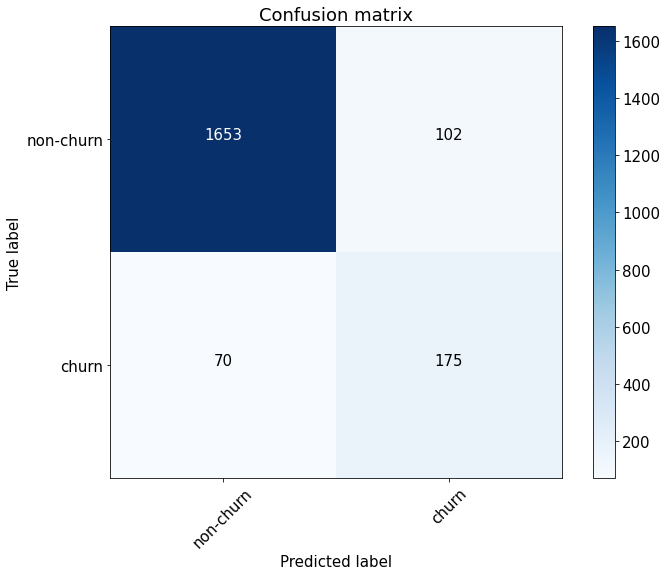

In [51]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [52]:
roc_auc_score(y_test, preds)

0.9436316064887493